# 1. Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sns.set_style("whitegrid")

# 2. Load Data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

TARGET = 'SalePrice'
ID_COL = 'Id'

X = train_df.drop([ID_COL, TARGET], axis=1)
y = train_df[TARGET]

y_log = np.log1p(y)

X_train, X_test_holdout, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

print('Training data shape:', X_train.shape)
print('Hold-out test data shape:', X_test_holdout.shape)
print('Test data (for submission) shape:', test_df.shape)

Training data shape: (1168, 79)
Hold-out test data shape: (292, 79)
Test data (for submission) shape: (1459, 80)


# 3. Data Preprocessing & Modeling Pipeline

In [3]:
numerical_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print('Preprocessing pipeline successfully created.')

Preprocessing pipeline successfully created.


# 4. Model Training & Evaluation

In [4]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

results = {}
for name, model in models.items():
    print(f'\nEvaluating the model: {name}')
    
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    
    cv_scores = cross_val_score(full_pipeline, X_train, y_train_log, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    
    mae_scores = []
    r2_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold_log, y_val_fold_log = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]
        
        full_pipeline.fit(X_train_fold, y_train_fold_log)
        y_pred_fold_log = full_pipeline.predict(X_val_fold)
        
        mae_scores.append(mean_absolute_error(np.expm1(y_val_fold_log), np.expm1(y_pred_fold_log)))
        r2_scores.append(r2_score(y_val_fold_log, y_pred_fold_log))

    results[name] = {
        'CV_RMSE': np.mean(rmse_scores),
        'CV_MAE': np.mean(mae_scores),
        'CV_R2': np.mean(r2_scores)
    }
    
    print(f'  Mean CV RMSE: {results[name]['CV_RMSE']:.4f}')
    print(f'  Mean CV MAE: {results[name]['CV_MAE']:.2f}')
    print(f'  Mean CV R²: {results[name]['CV_R2']:.4f}')

comparison_df = pd.DataFrame(results).T
print('\nModel Comparison (Cross-Validation):\n', comparison_df)


Evaluating the model: Linear Regression
  Mean CV RMSE: 0.1693
  Mean CV MAE: 18364.74
  Mean CV R²: 0.8192

Evaluating the model: Random Forest
  Mean CV RMSE: 0.1439
  Mean CV MAE: 18452.47
  Mean CV R²: 0.8561

Evaluating the model: XGBoost
  Mean CV RMSE: 0.1442
  Mean CV MAE: 18077.56
  Mean CV R²: 0.8600

Model Comparison (Cross-Validation):
                     CV_RMSE        CV_MAE     CV_R2
Linear Regression  0.169338  18364.738851  0.819204
Random Forest      0.143884  18452.470793  0.856121
XGBoost            0.144156  18077.558430  0.859975


# 5. Final Model Training & Evaluation on Hold-out Set

In [5]:
best_model_name = 'XGBoost' 
best_model = models[best_model_name]

print(f'\nTraining the final pipeline with the {best_model_name} model on the entire training data...')
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', best_model)])
final_pipeline.fit(X_train, y_train_log)
print('Final training completed.')

print('\nEvaluating the model on the hold-out set (unseen test data)...')
y_pred_log = final_pipeline.predict(X_test_holdout)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test_log)

final_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
final_mae = mean_absolute_error(y_true, y_pred)
final_r2 = r2_score(y_test_log, y_pred_log) 

print(f'  RMSE on Hold-out Set: {final_rmse:.2f}')
print(f'  MAE on Hold-out Set: {final_mae:.2f}')
print(f'  R² on Hold-out Set: {final_r2:.4f}')


Training the final pipeline with the XGBoost model on the entire training data...
Final training completed.

Evaluating the model on the hold-out set (unseen test data)...
  RMSE on Hold-out Set: 26259.47
  MAE on Hold-out Set: 17175.15
  R² on Hold-out Set: 0.8877


# 6. Model Interpretability with SHAP


Generating interpretability analysis with SHAP...
Plotting the SHAP summary plot...


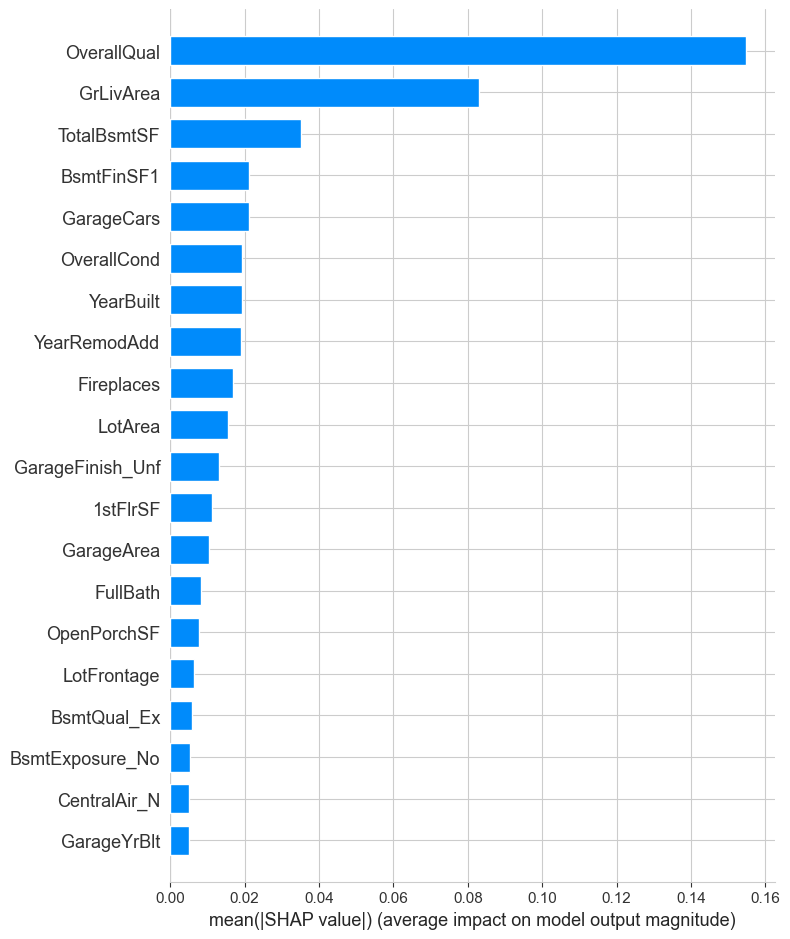

In [6]:
print('\nGenerating interpretability analysis with SHAP...')

regressor = final_pipeline.named_steps['regressor']
explainer = shap.Explainer(regressor)

processed_train_data = preprocessor.fit_transform(X_train)

feature_names_list = list(numerical_features) + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

sample_data_for_shap = processed_train_data[:500]

shap_values = explainer(sample_data_for_shap)

print('Plotting the SHAP summary plot...')
shap.summary_plot(shap_values, sample_data_for_shap, feature_names=feature_names_list, plot_type='bar')

# 7. Generate Submission & Save Artifacts

In [7]:
test_predictions_log = final_pipeline.predict(test_df.drop(ID_COL, axis=1))
test_predictions = np.expm1(test_predictions_log)

submission = pd.DataFrame({
    'Id': test_df[ID_COL],
    'SalePrice': test_predictions
})

submission.to_csv('submission_final.csv', index=False)
print("Submission file 'submission_final.csv' created successfully.")

joblib.dump(final_pipeline, 'final_pipeline.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
print("Artifacts (pipeline and preprocessor) saved as 'final_pipeline.pkl' and 'preprocessor.pkl'.")

!pip freeze > requirements.txt

Submission file 'submission_final.csv' created successfully.
Artifacts (pipeline and preprocessor) saved as 'final_pipeline.pkl' and 'preprocessor.pkl'.
